In [1]:
import pandas as pd
import matplotlib.pyplot as plt


open_data = pd.read_csv('data/open_data_0_gps.csv')
occulded_data = pd.read_csv('data/occluded_data_0_gps.csv')
straight_line_data = pd.read_csv('data/straight_line_data_1_gps.csv')

# preprocess data
# remove the last 40 rows of the open data as i didn't turn off the gps until i was back in the house
open_data = open_data[:-40]



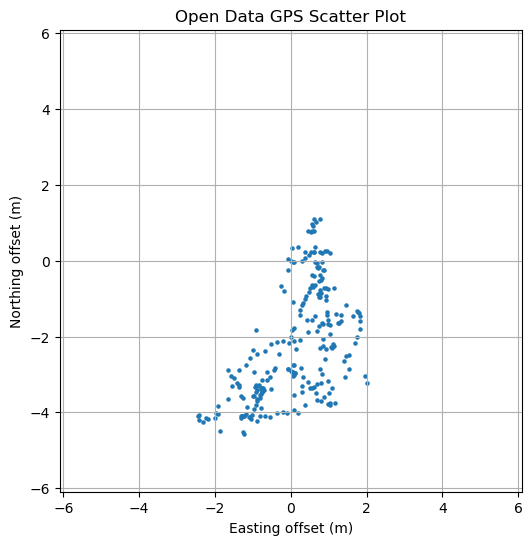

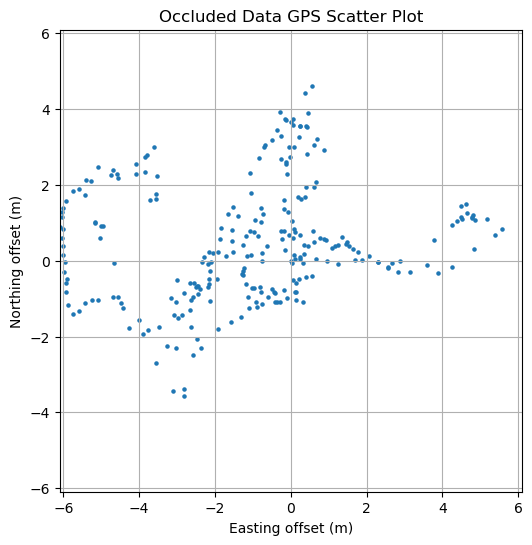

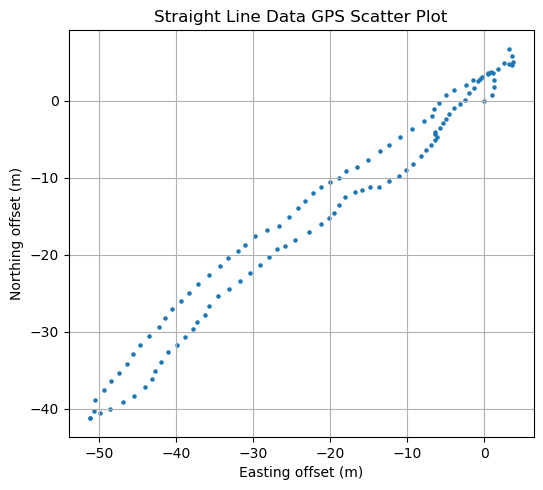

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_gps_scatter(df, title, lims=None):

    e = df['utm_easting'] - df['utm_easting'].iloc[0]
    n = df['utm_northing'] - df['utm_northing'].iloc[0]

    plt.figure(figsize=(6,6))
    plt.scatter(e, n, s=5)

    plt.xlabel('Easting offset (m)')
    plt.ylabel('Northing offset (m)')
    plt.title(title)
    plt.gca().set_aspect('equal')
    plt.grid(True)

    if lims is not None:
        plt.xlim(lims)
        plt.ylim(lims)

    plt.show()


def get_limits(*dfs):
    all_e = []
    all_n = []

    for df in dfs:
        e = df['utm_easting'] - df['utm_easting'].iloc[0]
        n = df['utm_northing'] - df['utm_northing'].iloc[0]
        all_e.extend(e)
        all_n.extend(n)

    m = max(np.max(np.abs(all_e)), np.max(np.abs(all_n)))
    return (-m, m)

lims = get_limits(open_data, occulded_data)

plot_gps_scatter(open_data, 'Open Data GPS Scatter Plot', lims)
plot_gps_scatter(occulded_data, 'Occluded Data GPS Scatter Plot', lims)


plot_gps_scatter(straight_line_data, 'Straight Line Data GPS Scatter Plot')


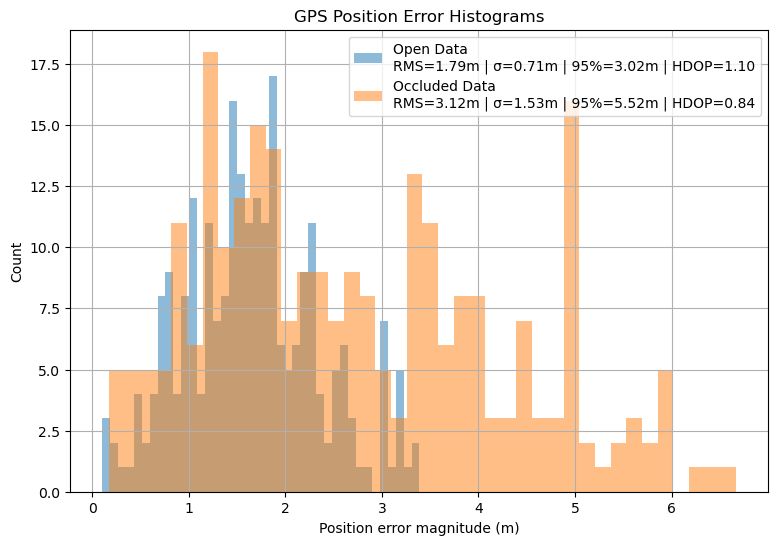

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_error_histograms(datasets, bins=40):
    """
    datasets = list of (df, label) tuples
    """

    plt.figure(figsize=(9,6))

    for df, label in datasets:

        # known position = mean
        E_known = df['utm_easting'].mean()
        N_known = df['utm_northing'].mean()

        dE = df['utm_easting'] - E_known
        dN = df['utm_northing'] - N_known
        error = np.sqrt(dE**2 + dN**2)

        # stats
        rms = np.sqrt((error**2).mean())
        std = error.std()
        p95 = np.percentile(error, 95)
        hdop = df['hdop'].mean()

        legend_label = (
            f"{label}\n"
            f"RMS={rms:.2f}m | σ={std:.2f}m | 95%={p95:.2f}m | HDOP={hdop:.2f}"
        )

        plt.hist(error, bins=bins, alpha=0.5, label=legend_label)

    plt.xlabel("Position error magnitude (m)")
    plt.ylabel("Count")
    plt.title("GPS Position Error Histograms")
    plt.legend()
    plt.grid(True)

    plt.show()

plot_error_histograms([
    (open_data, 'Open Data'),
    (occulded_data, 'Occluded Data'),
])


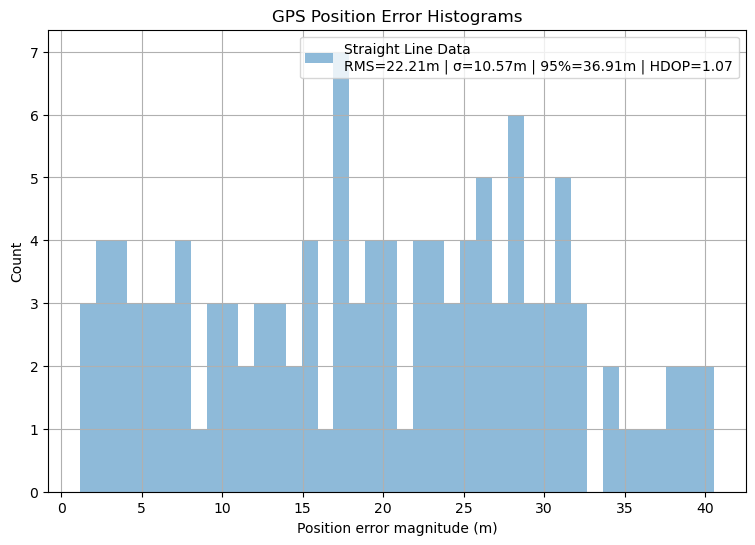

In [4]:
plot_error_histograms([
    (straight_line_data, 'Straight Line Data'),
])

In [5]:
def plot_altitude_vs_time_all(datasets):
    """
    datasets = list of (df, label) tuples
    """

    plt.figure(figsize=(10,5))

    for df, label in datasets:

        t = (df['bag_time_ns'] - df['bag_time_ns'].iloc[0]) / 1e9
        alt = df['altitude']

        plt.scatter(t, alt, label=label, s=5)   # line is nicer than scatter here

    plt.xlabel("Time (s)")
    plt.ylabel("Altitude (m)")
    plt.title("Altitude vs Time Comparison")
    plt.legend()
    plt.grid(True)

    plt.show()


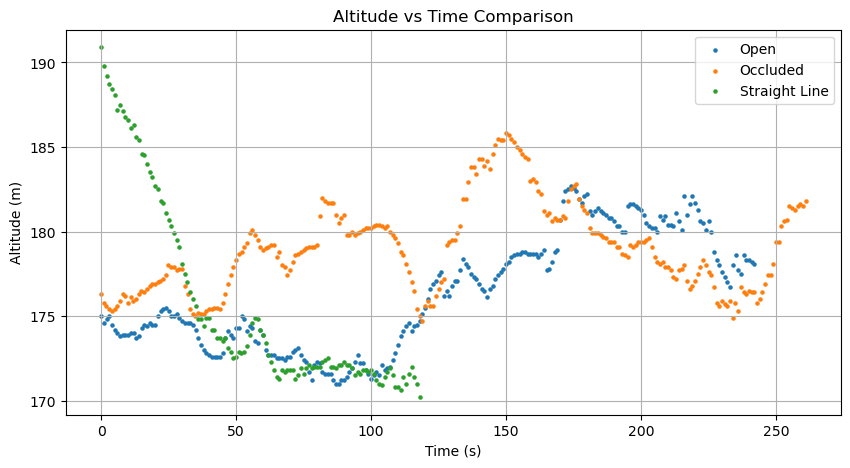

In [ ]:
plot_altitude_vs_time_all([
    (open_data, "Open"),
    (occulded_data, "Occluded"),
    (straight_line_data, "Straight Line"),
])


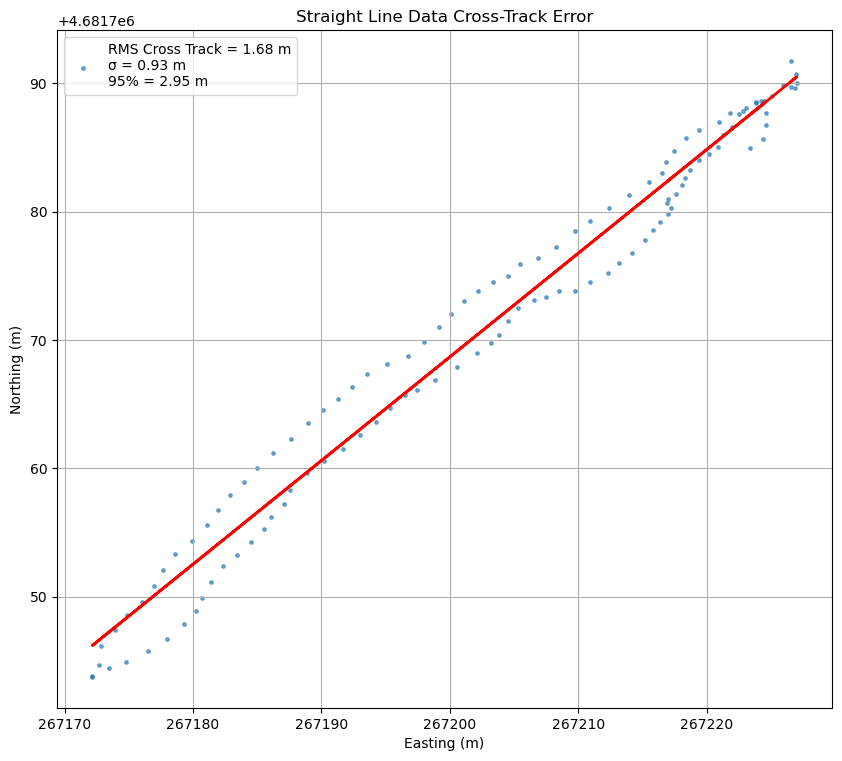

array([2.00534059, 2.1150741 , 1.37302668, 0.66826901, 0.11344218,
       0.30331365, 0.41887261, 0.55902127, 0.57726097, 0.09807253,
       0.06209888, 0.37794996, 0.36685121, 0.25182539, 0.43192313,
       0.69769879, 0.95236673, 1.18217782, 1.1009994 , 1.29325437,
       1.80337339, 1.99589498, 2.11384597, 2.22174748, 2.44785831,
       2.59437353, 2.61368798, 2.62189464, 2.34344288, 2.12581236,
       1.34966584, 1.0656561 , 0.70654256, 0.4019079 , 0.69227914,
       1.07864449, 1.15851251, 1.08288824, 0.95384839, 0.7028982 ,
       0.40646016, 0.10843241, 0.22003624, 0.31365738, 0.31736638,
       0.32609957, 0.16188382, 0.00444835, 0.23250246, 0.78678824,
       0.99226791, 1.31040123, 1.48494021, 1.5915159 , 1.60394761,
       2.00458875, 2.43907873, 2.95025801, 3.16472695, 3.26759896,
       3.01531679, 2.66413062, 2.1434327 , 1.87184449, 1.90886721,
       1.48072594, 0.45942767, 0.17964136, 0.16096825, 0.24453475,
       0.595194  , 1.10372878, 1.47237101, 1.49908266, 1.70588

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_line_fit_error(df, title):

    E = df['utm_easting'].values
    N = df['utm_northing'].values

    # ---- fit line ----
    m, b = np.polyfit(E, N, 1)
    N_fit = m*E + b

    # ---- perpendicular distance (cross-track error) ----
    error = np.abs(m*E - N + b) / np.sqrt(m**2 + 1)

    # stats
    rms = np.sqrt((error**2).mean())
    std = error.std()
    p95 = np.percentile(error, 95)

    # ---- plot ----
    plt.figure(figsize=(10,10))

    plt.scatter(E, N, s=6, alpha=0.6)

    legend_label = (
        
        f"RMS Cross Track = {rms:.2f} m\n"
        f"σ = {std:.2f} m\n"
        f"95% = {p95:.2f} m"
    )

    plt.plot(E, N_fit, 'r', linewidth=2)

    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    plt.title(title)
    plt.legend([legend_label])
    plt.gca().set_aspect('equal')
    plt.grid(True)

    plt.show()

    return error


plot_line_fit_error(straight_line_data, "Straight Line Data Cross-Track Error")

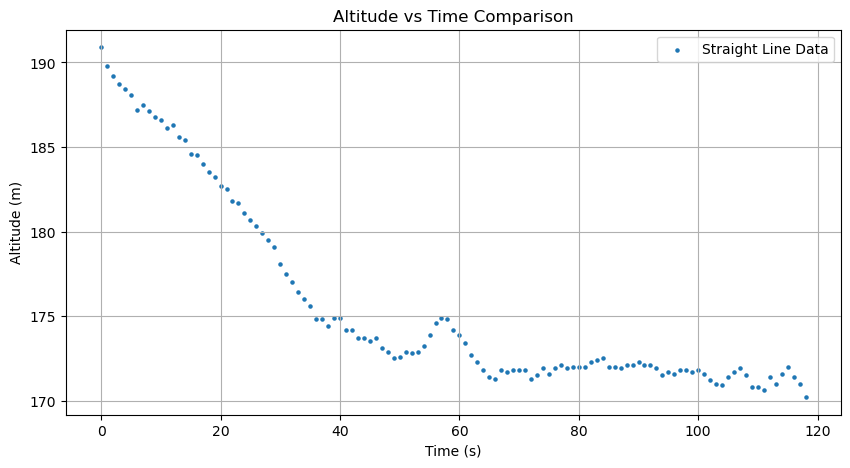

In [8]:
# plot altitude vs time for straight line data
plot_altitude_vs_time_all([
    (straight_line_data, "Straight Line Data"),
])